<a href="https://colab.research.google.com/github/Div99/XQL/blob/main/Gumbel_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Gumbel Regression**
By Div Garg\*, Joey Hejna\*, Matthieu Geist, Stefano Ermon

In this notebook, we explore the **Gumbel regression** loss, and show its ability to **accurately estimate log-partition functions**.

Gumbel Regression fits a Gumbel distribution $\mathcal{G}(\mu, \beta) = \exp{(-\exp{((x-\mu)/\beta)})}$ using Maxiumum Likelihood Estimation (MLE) to the estimation errors for learning a model $\hat{y}$ using samples \{(x1, y1) ..., (xN, yN)\}

This gives the Gumbel Regression Loss:

$$
\mathcal{L}(y) = \exp{(y-\hat{y})/\beta} - (y-\hat{y})/\beta - 1
$$

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from scipy import stats
from functools import partial
import seaborn as sns

## The Gumbel Distribution
Below we visualize the gumbel distribution with $\mu=0$ and varying values of beta.

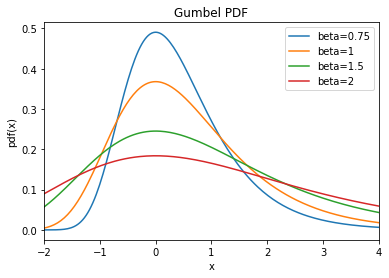

In [2]:
betas = [0.75, 1, 1.5, 2]
ax = plt.gca()
x = np.linspace(-2, 4, 200)
for beta in betas:
    sns.lineplot(ax=ax, x=x, y=stats.gumbel_r.pdf(x, 0.0, beta), label="beta="+str(beta))

ax.legend()
ax.set_ylabel("pdf(x)")
ax.set_xlabel("x")
ax.set_title("Gumbel PDF")
ax.set_xlim(-2, 4)
plt.show()

## Gumbel Loss
Below we can visualize the Gumbel loss function for different values of the temperature Beta.

In particular, for $\beta \rightarrow \infty, \ \mathcal{L(y)} \approx \frac{1}{2} (y - \hat{y})^2$ and for high temperature the Gumbel Loss behaves like MSE loss.

In [3]:
def gumbel_loss_numpy(diff, beta):
    '''
    diff: y - x, where x is prediction and y is the label
    beta: temperature (scale parameter) for the gumbel
    '''
    return np.exp(diff/beta) -diff/beta  - 1

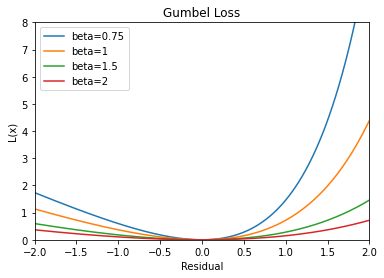

In [4]:
ax = plt.gca()
betas = [0.75, 1, 1.5, 2]
diff = np.linspace(-2, 2, 200)
for beta in betas:
    sns.lineplot(ax=ax, x=diff, y=gumbel_loss_numpy(diff, beta), label="beta="+str(beta))

ax.legend()
ax.tick_params(axis='y')
ax.tick_params(axis='x')
ax.set_ylabel("L(x)")
ax.set_xlabel("Residual")
ax.set_title("Gumbel Loss")
ax.set_ylim(0, 8)
ax.set_xlim(-2, 2)
plt.show()

## Gumbel Loss Functions
A problem with the normal gumbel loss function is that it can be too sensitive to outliers due to the exponential term. 

In order to combat this, we scale the gradients with the max value and optionally clip the exponent.

In [5]:
def gumbel_loss(diff, beta):
    z = diff/beta
    loss = torch.exp(z) - z - 1 
    return loss

def gumbel_stable_loss(diff, beta, clip=None):
    z = diff/beta
    if clip is not None:
        z = torch.clamp(z, max=clip)
    max_z = torch.max(z)
    max_z = torch.where(max_z < -1.0, torch.tensor(-1.0, dtype=torch.double, device=max_z.device), max_z)
    max_z = max_z.detach() # Detach the gradients
    loss = torch.exp(z - max_z) - z*torch.exp(-max_z) - torch.exp(-max_z)    # scale by e^max_z
    return loss

# Check Bias of Estimated Log-Partitions

We calculate Log-Partitions analytically vs using the Gumbel Loss and show the estimated Log-Partition function is unbiased

In [6]:
from scipy.special import logsumexp

def log_partition(x, beta):
    """Analytically calculate the Log-Partition over an emperical distribution 
    """
    n = x.shape[0]
    return beta * logsumexp(x/beta) - beta * np.log(n)

def solver_1d(data, loss_fn, lr=0.005, batch=128, steps=4000):
    """ Estimate Log-Partition function using Gumbel loss with SGD
    """
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data)
    statistic = torch.zeros(1, requires_grad=True)
    optim = torch.optim.SGD([statistic], lr=lr)
    for _ in range(steps):
        # Sample a batch
        perm = torch.randperm(data.size(0))
        idx = perm[:batch]
        samples = data[idx]

        optim.zero_grad()
        loss = torch.mean(loss_fn(samples-statistic))
        loss.backward()
        optim.step()
    return statistic.detach().cpu().numpy()

We plot the analytic vs estimated log-partitions using SGD for temperatures: {0.25, 0.5, 1, 2} and find them to match upto 7 decimal digits!

In [7]:
def plot_gumbel_bias(min=False):
    loss_fn = gumbel_loss # gumbel_stable_loss
    plt.clf()
    fig, ax = plt.subplots()
    betas = [0.25, 0.5, 1, 2]
    x = np.linspace(-3, 3, 500)
    y = stats.norm.pdf(x, loc=0.0, scale=1.0)
    plt.plot(x, y)
    data = np.random.normal(loc=0.0, scale=1.0, size=1000)

    # Plot estimated log-partitions
    for beta in betas:
        expectile = solver_1d(data, partial(loss_fn, beta=beta), lr=0.02, steps=2000)
        plt.axvline(x=expectile, label=f"estimated (beta={beta})", color = next(ax._get_lines.prop_cycler)['color'])
    plt.title("Gumbel " + ("min" if min else "max") + " Modes")
    plt.xlabel("x")
    plt.ylabel("pdf")
    plt.legend(loc='center left')
    plt.show()

    plt.plot(x, y)
    # Plot true log-partitions
    for beta in betas:
        opt = log_partition(data, beta)
        plt.axvline(x=opt, label=f"true (beta={beta})", color = next(ax._get_lines.prop_cycler)['color'])
    plt.title("Gumbel " + ("min" if min else "max") + " Modes")
    plt.xlabel("x")
    plt.ylabel("pdf")
    plt.legend(loc='center left')
    plt.show()

<Figure size 432x288 with 0 Axes>

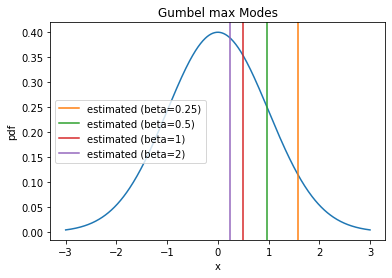

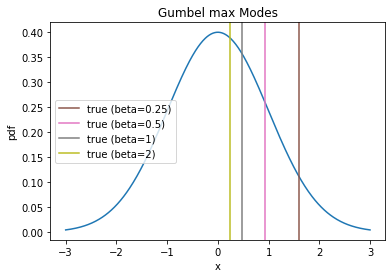

In [8]:
plot_gumbel_bias()

In [9]:
def gumbel_bias():
    loss_fn = gumbel_loss

    x = np.linspace(-3, 3, 500)
    y = stats.norm.pdf(x, loc=0.0, scale=1.0)
    betas = [0.25, 0.5, 1, 2]

    N = 100
    data = np.random.normal(loc=0.0, scale=1.0, size=N)
    for beta in betas:
        solves = []
        opt = log_partition(data, beta)
        # We estimate the log-partition function 10 times to calculate the mean and std of the estimations
        for times in range(10):
            expectile = solver_1d(data, partial(loss_fn, beta=beta), lr=0.02, steps=2000)
            solves.append(expectile[0])
            # print(solves)
        solves = np.array(solves)
        print(f"Temperature {beta}, Estimated log-partition: {solves.mean()}, True: {opt}")
        diff = solves - opt
        print(f"Estimation error: Mean: {diff.mean()}, Std: {diff.std()}\n\n")

gumbel_bias()

Temperature 0.25, Estimated log-partition: 1.376839518547058, True: 1.3768394050307116
Estimation error: Mean: 1.1920928955078125e-07, Std: 0.0


Temperature 0.5, Estimated log-partition: 0.9134770631790161, True: 0.9134773178979421
Estimation error: Mean: -2.980232238769531e-07, Std: 0.0


Temperature 1, Estimated log-partition: 0.4986351430416107, True: 0.49863585065197213
Estimation error: Mean: -7.450580596923828e-07, Std: 0.0


Temperature 2, Estimated log-partition: 0.23594553768634796, True: 0.23595541341674142
Estimation error: Mean: -9.879469871520996e-06, Std: 0.0




We can do the same with `gumbel_stable_loss` to find that it makes a bit more approximation errors but tends to be more stable for low temps.  

In RL, as the Q-functions shift over training, we find using this version to help a lot with the stability of the learnt Log-Partitions (or optimal soft-values) over the vanilla loss function. 

In [16]:
def gumbel_bias():
    loss_fn = gumbel_stable_loss

    x = np.linspace(-3, 3, 500)
    y = stats.norm.pdf(x, loc=0.0, scale=1.0)
    betas = [0.25, 0.5, 1, 2]

    N = 100
    data = np.random.normal(loc=0.0, scale=1.0, size=N)
    for beta in betas:
        solves = []
        opt = log_partition(data, beta)
        # We estimate the log-partition function 10 times to calculate the mean and std of the estimations
        for times in range(10):
            expectile = solver_1d(data, partial(loss_fn, beta=beta), lr=0.02, steps=2000)
            solves.append(expectile[0])
            # print(solves)
        solves = np.array(solves)
        print(f"Temperature {beta}, Estimated log-partition: {solves.mean()}, True: {opt}")
        diff = solves - opt
        print(f"Estimation error: Mean: {diff.mean()}, Std: {diff.std()}\n\n")

gumbel_bias()

Temperature 0.25, Estimated log-partition: 1.4846775531768799, True: 1.484681818290173
Estimation error: Mean: -4.291534423828125e-06, Std: 0.0


Temperature 0.5, Estimated log-partition: 0.9660857915878296, True: 0.9661079950007259
Estimation error: Mean: -2.2172927856445312e-05, Std: 0.0


Temperature 1, Estimated log-partition: 0.501707136631012, True: 0.5024058293247133
Estimation error: Mean: -0.0006986856460571289, Std: 0.0


Temperature 2, Estimated log-partition: 0.23666150867938995, True: 0.24349354013138935
Estimation error: Mean: -0.006832018494606018, Std: 0.0




## A simple example of Gumbel Regression
Here we look at a simple regression example for a quadratic with some gaussian noise.

In [11]:
coeffs = [-1, 0, 1]
x = np.linspace(-1, 1, 1000)
y = coeffs[0]*x*x + coeffs[1]*x + coeffs[2]
y += np.random.normal(loc=0.0, scale=0.2, size=y.shape[0])

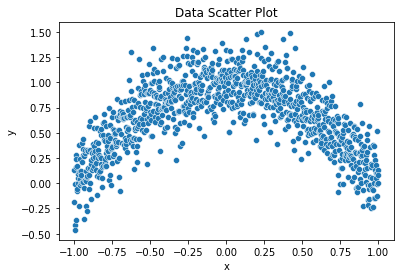

In [12]:
sns.scatterplot(x=x,y=y)
ax = plt.gca()
ax.set_title("Data Scatter Plot")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.show()

Now, we can use a Gumbel regression to fix the extrema of this data distribution. We define a simple solver using gradient descent over the Gumbel regression loss to predict the coefficients of a quadratic that approximates the Log-Partitions of the data. 

For low temps, this fits the maximal values of the data and for high temps it will fit the mean values of the data.

In [19]:
def solver_quadratic(x, y, beta, lr=0.005, steps=200):
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    params = torch.randn(3, requires_grad=True)
    optim = torch.optim.Adam([params], lr=lr)
    x_squared = x*x
    for _ in range(steps):
        pred = params[0]*x_squared + params[1]*x + params[2]
        optim.zero_grad()
        loss = torch.mean(gumbel_stable_loss(y - pred, beta))
        loss.backward()
        optim.step()
    print("Final Loss", loss.item())
    return params.detach().cpu().numpy()

Then, we can run the solver over a few values of beta, and plot the result.

Final Loss 0.017002962008426614
Final Loss 0.027786705202169346
Final Loss 0.0035719897326507684


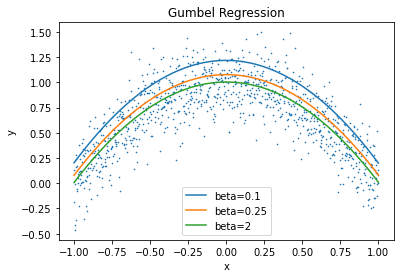

In [20]:
ax = plt.gca()
sns.scatterplot(ax=ax, x=x, y=y, s=2, edgecolor=None)

betas = [0.1, 0.25, 2]
for beta in betas:
    coeffs = solver_quadratic(x, y, beta, lr=0.01, steps=2000)
    y_hat = coeffs[0]*x*x + coeffs[1]*x + coeffs[2]
    sns.lineplot(ax=ax, x=x, y=y_hat, label="beta="+str(beta))
ax.legend()
ax.set_title("Gumbel Regression")
ax.set_ylabel("y")
ax.set_xlabel("x")
plt.show()

Notice how higher values of beta fit greater extremes of the distribution.